# RAPIDS & Scanpy Single-Cell RNA-seq Workflow

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2 and TMPRSS2 genes. See the README for instructions to download this dataset.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')

We use the RAPIDS memory manager on the GPU to control how memory is allocated.

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

We recommend saving count matrices in the sparse .h5ad format as it is much faster to load than a dense CSV file. To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
input_file = "./krasnow_hlca_10x_UMIs.sparse.h5ad"

## Set parameters

In [4]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [5]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [6]:
data_load_start = time.time()

In [7]:
%%time
adata = sc.read(input_file)
adata = adata.T

CPU times: user 4 s, sys: 758 ms, total: 4.75 s
Wall time: 4.75 s


In [8]:
adata.shape

(65662, 26485)

We maintain the index of unique cells and genes in our dataset:

In [9]:
%%time
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)

CPU times: user 825 ms, sys: 449 ms, total: 1.27 s
Wall time: 1.34 s


In [10]:
%%time
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 172 ms, sys: 401 ms, total: 572 ms
Wall time: 573 ms


Verify the shape of the resulting sparse matrix:

In [11]:
sparse_gpu_array.shape

(65662, 26485)

And the number of non-zero values in the matrix:

In [12]:
sparse_gpu_array.nnz

126510394

In [13]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 6.800417423248291


## Preprocessing

In [14]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [15]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

Running 7 batches
CPU times: user 583 ms, sys: 595 ms, total: 1.18 s
Wall time: 1.18 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [16]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=1)

CPU times: user 910 ms, sys: 213 ms, total: 1.12 s
Wall time: 1.12 s


The size of our count matrix is now reduced.

In [17]:
sparse_gpu_array.shape

(65462, 22058)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [18]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)

Target_sum=10000.0, dtype=<class 'float'>
Finished kernel
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 185 ms


Next, we log transform the count matrix.

In [19]:
%%time
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 57.2 ms, sys: 39.6 ms, total: 96.8 ms
Wall time: 96.7 ms


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [20]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()

CPU times: user 250 ms, sys: 189 ms, total: 439 ms
Wall time: 438 ms


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [21]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.61 s, sys: 24.8 ms, total: 1.63 s
Wall time: 1.63 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

Before regression, we save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of an epithelial marker gene (EPCAM).

In [22]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
ACE2_raw = tmp_norm[:, genes[genes == "ACE2"].index[0]].todense().ravel()
TMPRSS2_raw = tmp_norm[:, genes[genes == "TMPRSS2"].index[0]].todense().ravel()
EPCAM_raw = tmp_norm[:, genes[genes == "EPCAM"].index[0]].todense().ravel()

del tmp_norm

CPU times: user 401 ms, sys: 207 ms, total: 608 ms
Wall time: 613 ms


In [23]:
genes = adata.var_names
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [24]:
%%time
filtered = adata.X

CPU times: user 472 ms, sys: 32 ms, total: 504 ms
Wall time: 503 ms


We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [25]:
%%time
n_counts = filtered.sum(axis=1)
percent_ribo = (filtered[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 57.6 ms, sys: 476 µs, total: 58 ms
Wall time: 57 ms


And perform regression:

In [26]:
%%time
sparse_gpu_array = cp.sparse.csc_matrix(adata.X)
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_ribo)

CPU times: user 51.1 s, sys: 21.3 s, total: 1min 12s
Wall time: 1min 18s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [27]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.scale(sparse_gpu_array, max_value=10)

CPU times: user 159 ms, sys: 77.1 ms, total: 236 ms
Wall time: 238 ms


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 84.43733286857605


## Cluster & Visualize

In [29]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [30]:
%%time

var_names = adata.var_names
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw.get()
adata.obs["EPCAM_raw"] = EPCAM_raw.get()

CPU times: user 252 ms, sys: 285 ms, total: 537 ms
Wall time: 536 ms


### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [31]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)

CPU times: user 1.4 s, sys: 1.29 s, total: 2.69 s
Wall time: 2.69 s


### TSNE + K-means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [32]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

CPU times: user 1.09 s, sys: 761 ms, total: 1.85 s
Wall time: 1.85 s


We cluster the cells using k-means on the principal components. For example purposes, we set k=20.

In [33]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 81.1 ms, sys: 20.4 ms, total: 102 ms
Wall time: 101 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


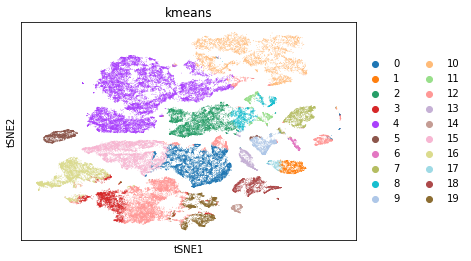

CPU times: user 13.7 s, sys: 977 ms, total: 14.6 s
Wall time: 583 ms


In [34]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

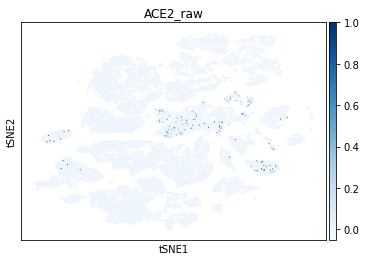

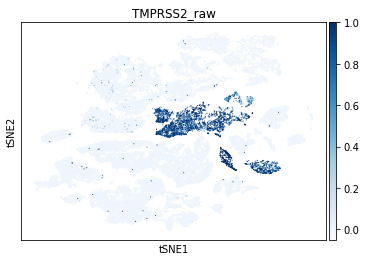

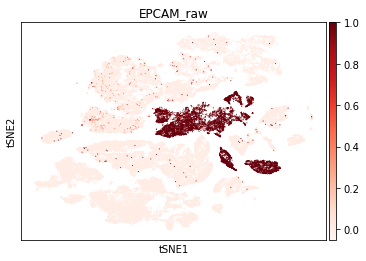

CPU times: user 43.1 s, sys: 2.97 s, total: 46.1 s
Wall time: 1.15 s


In [35]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [36]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 4.17 s, sys: 217 ms, total: 4.39 s
Wall time: 4.36 s


The UMAP function from Rapids is also integrated into Scanpy.

In [37]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 503 ms, sys: 270 ms, total: 773 ms
Wall time: 786 ms


Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [38]:
%%time
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

CPU times: user 445 ms, sys: 62.3 ms, total: 508 ms
Wall time: 511 ms


/raid/cnolet/miniconda3/envs/cuml_015_nightly/lib/python3.7/site-packages/cugraph/structure/graph.py:347: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

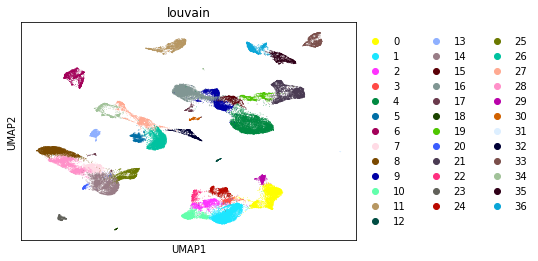

CPU times: user 13.9 s, sys: 1.06 s, total: 15 s
Wall time: 584 ms


In [39]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

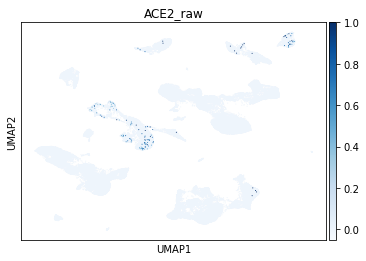

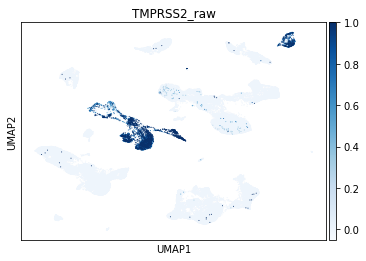

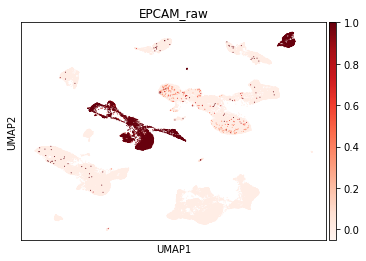

CPU times: user 41 s, sys: 3.25 s, total: 44.2 s
Wall time: 1.14 s


In [40]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [41]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 14.354747295379639


## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [42]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [43]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    sparse_gpu_array, 
    cluster_labels, 
    var_names, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

Ranking took (GPU): 4.181523084640503
Preparing output np.rec.fromarrays took (CPU): 0.0015881061553955078
Note: This operation will be accelerated in a future version
CPU times: user 3.05 s, sys: 1.15 s, total: 4.2 s
Wall time: 4.2 s


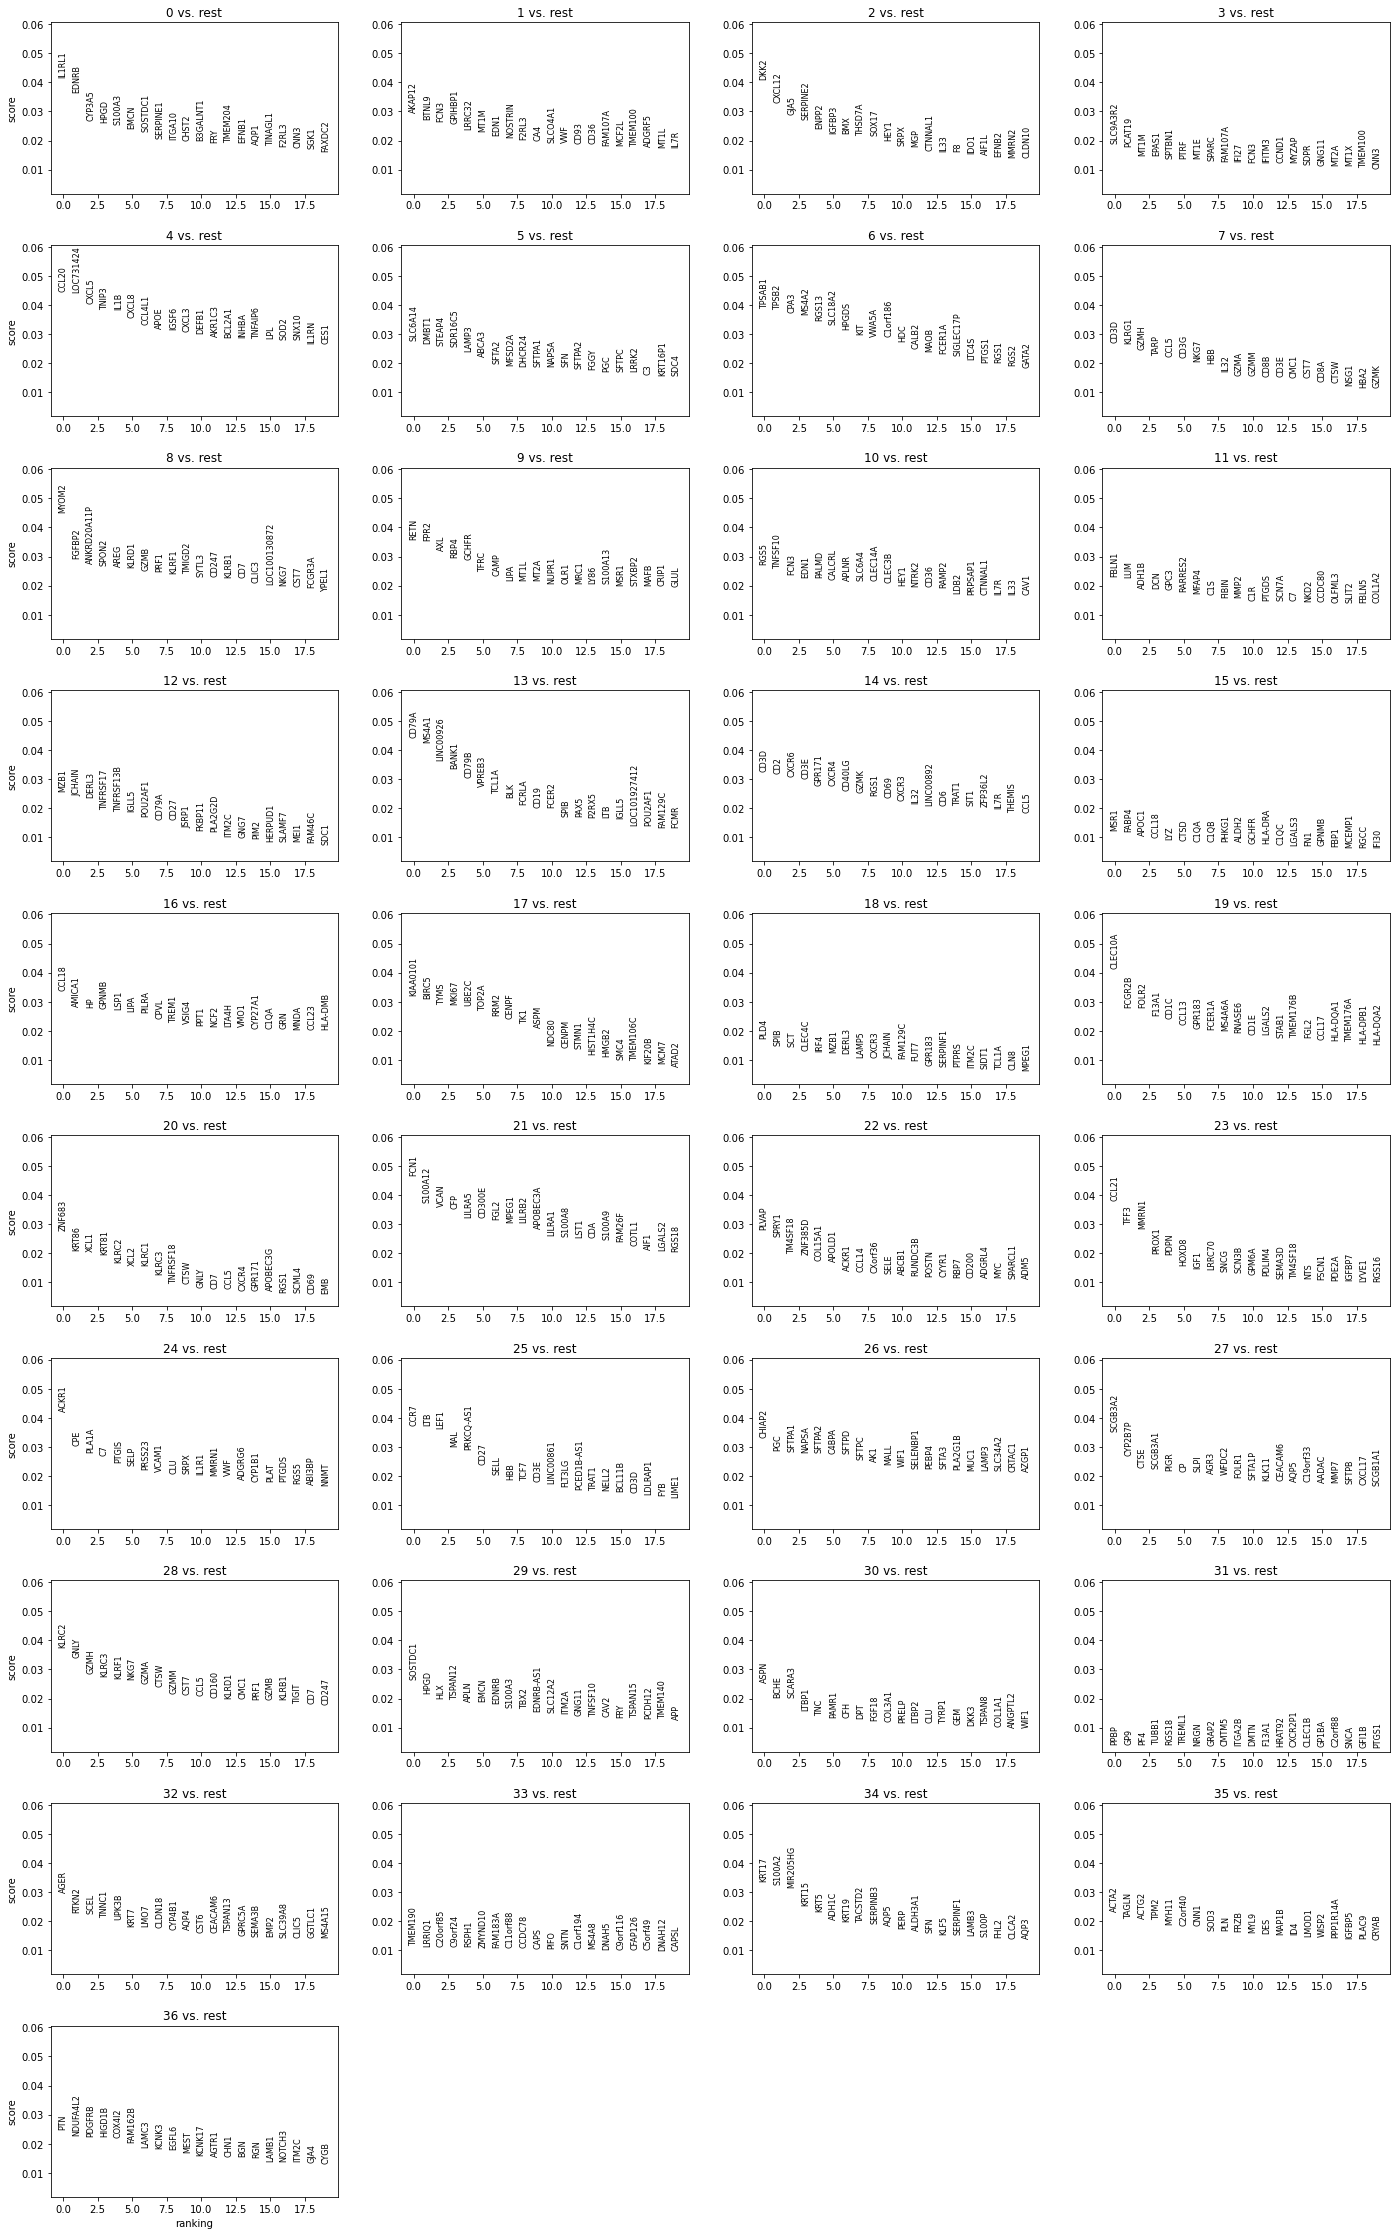

CPU times: user 5.39 s, sys: 136 ms, total: 5.52 s
Wall time: 5.51 s


In [44]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [45]:
reanalysis_start = time.time()

In [46]:
%%time

epcam_cells = adata.obs["EPCAM_raw"] > 0.0
adata = adata[epcam_cells,:]

CPU times: user 4.15 ms, sys: 28 µs, total: 4.18 ms
Wall time: 3.79 ms


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

/raid/cnolet/miniconda3/envs/cuml_015_nightly/lib/python3.7/site-packages/cugraph/structure/graph.py:347: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


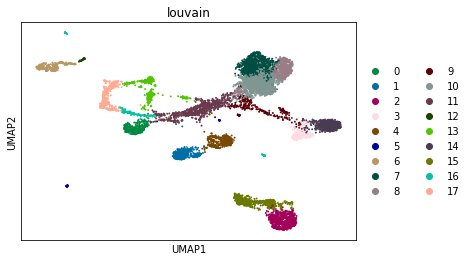

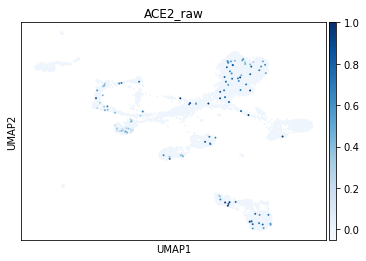

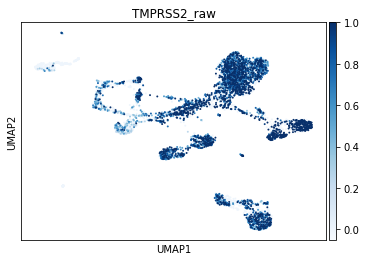

CPU times: user 1min 31s, sys: 24 s, total: 1min 55s
Wall time: 3.36 s


In [48]:
%%time

adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids', resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [49]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 3.3867311477661133


In [50]:
print("Full time: %s" % (time.time() - start))

Full time: 118.73655891418457
